# 4. Evaluation Metrics for Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?


## 4.1 Evaluation metrics: session overview 

* Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
* https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv


*Metric* - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'
path_to_data = "../../datasets/data-week-3.csv"
!wget $data -O $path_to_data

--2021-09-30 08:46:44--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977501 (955K) [text/plain]
Saving to: ‘../../datasets/data-week-3.csv’

../../datasets/data 100%[===================>] 954.59K  --.-KB/s    in 0.1s    

2021-09-30 08:46:45 (6.30 MB/s) - ‘../../datasets/data-week-3.csv’ saved [977501/977501]



In [4]:
df = pd.read_csv(path_to_data)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [7]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [8]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [9]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## 4.2 Accuracy and dummy model

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

- We could have cases where we predict incorrectly, for example, a customer will be churning when indeed is not. 



In [10]:
# How many customers we have in validation set
len(y_val)

1409

In [11]:
# check how many decisions are correct
(y_val == churn_decision).sum()

1132

In [12]:
# accuracy correct/total 
(y_val == churn_decision).sum() / len(y_val)

0.8034066713981547

In [13]:
# Could we move the decision threshold? 
thresholds = np.linspace(0,1,21)
scores = [] 
for t in thresholds:
    churn_decision = (y_pred >= t) 
    score = (y_val == churn_decision).mean()
    print(f"Threshold: {t:.2f} Score:{score:.3f}")
    scores.append(score)

Threshold: 0.00 Score:0.274
Threshold: 0.05 Score:0.509
Threshold: 0.10 Score:0.591
Threshold: 0.15 Score:0.666
Threshold: 0.20 Score:0.710
Threshold: 0.25 Score:0.739
Threshold: 0.30 Score:0.760
Threshold: 0.35 Score:0.772
Threshold: 0.40 Score:0.785
Threshold: 0.45 Score:0.793
Threshold: 0.50 Score:0.803
Threshold: 0.55 Score:0.801
Threshold: 0.60 Score:0.795
Threshold: 0.65 Score:0.786
Threshold: 0.70 Score:0.766
Threshold: 0.75 Score:0.744
Threshold: 0.80 Score:0.735
Threshold: 0.85 Score:0.726
Threshold: 0.90 Score:0.726
Threshold: 0.95 Score:0.726
Threshold: 1.00 Score:0.726


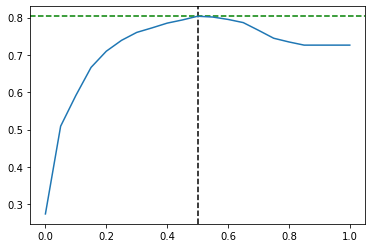

In [14]:
plt.axvline(x=0.5,color="black", linestyle="--")
plt.axhline(y=0.803,color="green", linestyle="--")
plt.plot(thresholds, scores)

In [15]:
# Calculating accuracy with sklearn
from sklearn.metrics import accuracy_score

In [16]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [17]:
# using accuracy_score from sklearn
scores = [] 
for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print(f"Threshold: {t:.2f} Score:{score:.3f}")
    scores.append(score)

Threshold: 0.00 Score:0.274
Threshold: 0.05 Score:0.509
Threshold: 0.10 Score:0.591
Threshold: 0.15 Score:0.666
Threshold: 0.20 Score:0.710
Threshold: 0.25 Score:0.739
Threshold: 0.30 Score:0.760
Threshold: 0.35 Score:0.772
Threshold: 0.40 Score:0.785
Threshold: 0.45 Score:0.793
Threshold: 0.50 Score:0.803
Threshold: 0.55 Score:0.801
Threshold: 0.60 Score:0.795
Threshold: 0.65 Score:0.786
Threshold: 0.70 Score:0.766
Threshold: 0.75 Score:0.744
Threshold: 0.80 Score:0.735
Threshold: 0.85 Score:0.726
Threshold: 0.90 Score:0.726
Threshold: 0.95 Score:0.726
Threshold: 1.00 Score:0.726


In [18]:
# Checking for values above 1.0 
y_pred >= 1.0

array([False, False, False, ..., False, False, False])

In [19]:
# Using a counter 
from collections import Counter

In [20]:
# Every customer will be non-churn
Counter(y_pred >= 1.0)

Counter({False: 1409})

In [21]:
# Looks at the distribution of y_Val
Counter(y_val)

Counter({0: 1023, 1: 386})

### Notes 

- f f f f f ---> everyone non-churn 
- 73 % of people who were predicted Correctly.
- This represents a class inbalance. 
- Cases with Class inbalance can be missleading

In [22]:
1 - y_val.mean()

0.7260468417317246

## 4.3 Confusion table

A way of looking at different errors and decisions the model makes. 

* Different types of errors and correct decisions
* Arranging them in a table


### Notes

Remember our function $g(x_i)$ 

- The model will output Churn if $g(x_i) >= t$
- The model will output No Churn if $g(x_i) >= t$

In [23]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [24]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [25]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [26]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [27]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## 4.4 Precision and Recall

### Notes

- Precision and recall are metrics to look for when working with binary classification.
- **Precision**: it's the fraction of True positive values that were detected over the sum of True Positive and False Positives. 
- **Recall**: It represents the fraction of True positives that were predicted over those correctly detected plus those that were detected as negative when in fact were positive. 

Why those metrics are important? 
- Because sometimes accuracy could be misleading, for example, Accuracy could be 80% but Precision and recall could be less, indicating that there might be problems with our model capturing data that shouldn't be capture and viceversa. 

For example: 

- Project: Identified customers who are churning on a mobile company

- Accuracy 80% 
- **Precision**: 67% Indicating that out 311 predictions as Positives, only 210 where actual positives, and 33% of them were predicted as positives when they were not. 

  On this example imagine, that for each predicted positive we will send an offer, this means that we are sending an offer to 33% of the customers, which in fact were not needed indicating that we might be losing money as they claim the offer. 
  
  On the other hand: 
  
- **Recall**: 54% --> 210 customers out of the total 386 ( True Positives and False Negatives) were detected correctly, but for 46% of customers, we failed to identify they are churning, so we missed sending the offer and customer leaves, as a consequence the company also lose money. 

In [28]:
# Calculate precision 
p = tp / (tp + fp)
p

0.6752411575562701

In [29]:
# Calculate recall
r = tp / (tp + fn)
r

0.5440414507772021

## 4.5 ROC Curves

### TPR and FRP

### Notes

- ROC: Receiving operating characteristics, wya of describing performance of binary classification model

We are interested in two metrics, computed from values in the confusion matrix.

- True Positive Rate or **TPR**: is the fraction of True Positive among all positive examples ( True Positives and those failed to detect were positive [ False Negatives ] ) 
  We are interested on the 2nd row of the confusion matrix

- False Positive Rate or **FPR**: is the fraction of False positives among all negative examples ( False Positives ( those detected as positive but in fact it wasn't ) and True Negatives ) 
    We are interested on the 2nd row of the confusion matrix on the 1st row of confusion matrix
    

- For FPR: we want to make it as low as possible. Minimise the amount of False positive detected.
- For TPR: we want to maximize the the amount of True Positive detected. 

In [31]:
# TPR 
tpr = tp / ( tp + fn )
tpr

0.5440414507772021

In [32]:
# FPR 
fpr = fp / ( fp + tn)
fpr

0.09872922776148582

### ROC Curve 

- We will look at all the possible thresholds

In [35]:
thresholds = np.linspace(0,1,101)
scores = []

In [36]:
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t,tp,fp,fn,tn)) 

In [37]:
scores

[(0.0, 386, 1023, 0, 0),
 (0.01, 385, 913, 1, 110),
 (0.02, 384, 830, 2, 193),
 (0.03, 383, 766, 3, 257),
 (0.04, 381, 715, 5, 308),
 (0.05, 379, 685, 7, 338),
 (0.06, 377, 661, 9, 362),
 (0.07, 372, 641, 14, 382),
 (0.08, 371, 613, 15, 410),
 (0.09, 369, 580, 17, 443),
 (0.1, 366, 556, 20, 467),
 (0.11, 365, 528, 21, 495),
 (0.12, 365, 509, 21, 514),
 (0.13, 360, 477, 26, 546),
 (0.14, 355, 453, 31, 570),
 (0.15, 351, 435, 35, 588),
 (0.16, 347, 419, 39, 604),
 (0.17, 346, 401, 40, 622),
 (0.18, 344, 384, 42, 639),
 (0.19, 338, 369, 48, 654),
 (0.2, 333, 356, 53, 667),
 (0.21, 330, 341, 56, 682),
 (0.22, 323, 322, 63, 701),
 (0.23, 320, 313, 66, 710),
 (0.24, 316, 304, 70, 719),
 (0.25, 309, 291, 77, 732),
 (0.26, 304, 281, 82, 742),
 (0.27, 303, 270, 83, 753),
 (0.28, 295, 256, 91, 767),
 (0.29, 291, 244, 95, 779),
 (0.3, 284, 236, 102, 787),
 (0.31, 280, 230, 106, 793),
 (0.32, 278, 226, 108, 797),
 (0.33, 276, 221, 110, 802),
 (0.34, 274, 212, 112, 811),
 (0.35000000000000003, 272,

In [38]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

In [39]:
df_scores

,threshold,tp,fp,fn,tn
0,0.00,386,1023,0,0
1,0.01,385,913,1,110
2,0.02,384,830,2,193
3,0.03,383,766,3,257
4,0.04,381,715,5,308
...,...,...,...,...,...
96,0.96,0,0,386,1023
97,0.97,0,0,386,1023
98,0.98,0,0,386,1023
99,0.99,0,0,386,1023


In [40]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

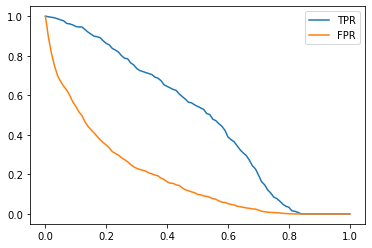

In [41]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

### Notes

- On the chart above, when TPR and FPR are 1, it means the it predicts everyone as churning. For FPR is 100% meaning we predict all of them incorrectly.


### Random model

In [42]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [43]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [44]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [45]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

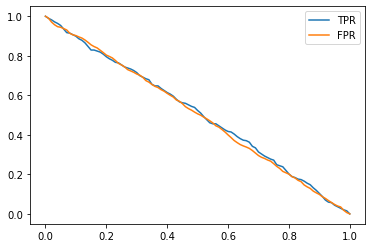

In [46]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

### Ideal model

In [47]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [48]:

y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

y_ideal_pred = np.linspace(0, 1, len(y_val))

In [49]:
1 - y_val.mean()

0.7260468417317246

In [50]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

In [51]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


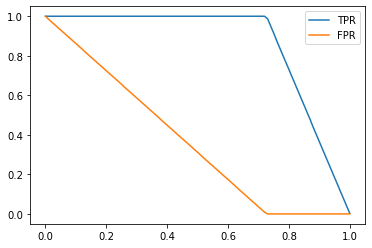

In [52]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

### Putting everything together

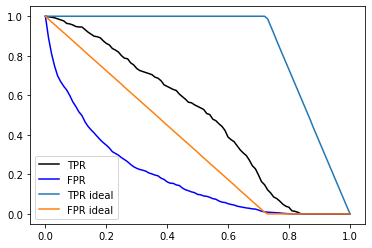

In [59]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

#plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
#plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()

### Notes

- We want the model to be as closest to the ideal. 


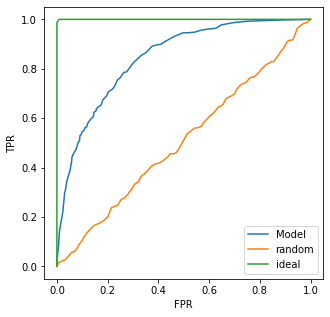

In [63]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot(df_rand.fpr, df_rand.tpr, label='random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

#plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [64]:
from sklearn.metrics import roc_curve

In [65]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

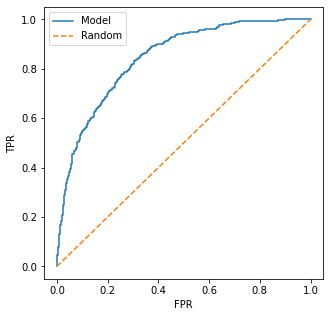

In [66]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## 4.6 ROC AUC

* Area under the ROC curve - useful metric
* Interpretation of AUC


### Notes 

- We can check the area under the curve, which will help us to see how good our classifier is. 
- We want our model to be as closest to ideal with : TPR close to 1 and FPR close to 0 
- For this we can calculate the AUC, which will tell us how good our model is. It helps evaluating the quality of the model. 

- Our model should be with AUC between 0.5 and 1. 

Intepretation: 
- AUC tells a probability that a randomly selected positive example has a score of a randomly 
selective negative example. 


In [67]:
from sklearn.metrics import auc

In [68]:
auc(fpr, tpr)

0.8438581030090306

In [69]:
# For the model 
auc(df_scores.fpr, df_scores.tpr)

0.8438732975754537

In [70]:
# For ideal
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [71]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8438581030090306

In [72]:
from sklearn.metrics import roc_auc_score

In [73]:
roc_auc_score(y_val, y_pred)

0.8438581030090306

In [75]:
# Demonstration of AUC probability 
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [76]:
import random

In [77]:
n = 100000
success = 0 

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.84568

In [78]:
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.84648

## 4.7 Cross-Validation

* Evaluating the same model on different subsets of data
* Getting the average prediction and the spread within predictions

### Notes

* Parameter tuning, process of selecting best parameters for training the model. 
* It's not the only way to validate the model. We could work with validation set.
    * Split training set into multiple parts ( Folds ) 
    
Suppose we split the train set into 3 sets. We can do: 

- Train on 1 and 2, Val on 3.
- Train on 1 and 3, Val on 2.
- Train on 2 and 3, Val on 1. 

Compute: AUC for each fold along with mean and std. This will tell us how stable and how much scores differ on different folds


In [88]:
def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    # Create the model 
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    return dv, model

In [89]:
dv, model = train(df_train, y_train)

In [92]:
def predict(df,dv,model):
    
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred

In [93]:
y_pred = predict(df_val, dv, model)

In [94]:
y_pred

array([0.0089964 , 0.20451761, 0.21222019, ..., 0.13638789, 0.7997773 ,
       0.83741357])

In [95]:
from sklearn.model_selection import KFold

In [96]:
# Create the folds for splitting the dataset
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [98]:
# For demonstration purposes :) 
train_idx, val_idx = next(kfold.split(df_full_train))
len(train_idx)

5070

In [99]:
len(val_idx)

564

In [100]:
# Split dataset using iloc
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

In [106]:
import warnings
warnings.filterwarnings('ignore')

In [112]:
!pip install tqdm

In [114]:
from tqdm.auto import tqdm

In [115]:
scores = [] 
# Using the full generator 
for train_idx, val_idx in tqdm(kfold.split(df_full_train)): 
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.churn.values
    y_val = df_val.churn.values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv,model)
    
    # Calculate AUC score
    scores.append(roc_auc_score(y_val, y_pred))

0it [00:00, ?it/s]

In [116]:
scores

[0.8479398247539081,
 0.8411045792079208,
 0.8557048652060528,
 0.8340794996296602,
 0.8277605459057072,
 0.8342657342657342,
 0.8412569195701727,
 0.8186669829222013,
 0.8456350970801838,
 0.8627777217572519]

In [120]:
# Compute mean and std of scores
mean_score, std_score = np.mean(scores), np.std(scores)
print(f"mean_score: {mean_score:.3f} +- std:{std_score:.3f}")

mean_score: 0.841 +- std:0.012


In [121]:
# Adding Parameter Tuning. 
# Logistic Regression has the parameter C let's edit our previous function

In [122]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [129]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        # Split the dataset
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        # Get the targets 
        y_train = df_train.churn.values
        y_val = df_val.churn.values

        # Train the model with C parameters 
        dv, model = train(df_train, y_train, C=C)
        # Get the predictions
        y_pred = predict(df_val, dv, model)

        # Get the AUC scores
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.008
C=0.1 0.841 +- 0.008
C=0.5 0.840 +- 0.006
C=1 0.841 +- 0.009
C=5 0.841 +- 0.008
C=10 0.841 +- 0.007


In [130]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259

## 4.8 Summary

* Metric - a single number that describes the performance of a model
* Accuracy - fraction of correct answers; sometimes misleading 
* Precision and recall are less misleading when we have class inbalance
* ROC Curve - a way to evaluate the performance at all thresholds; okay to use with imbalance
* K-Fold CV - more reliable estimate for performance (mean + std)

## 4.9 Explore more

* Check the precision and recall of the dummy classifier that always predict "FALSE"
* F1 score = 2 * P * R / (P + R)
* Evaluate precision and recall at different thresholds, plot P vs R - this way you'll get the precision/recall curve (similar to ROC curve)
* Area under the PR curve is also a useful metric

Other projects:

* Calculate the metrics for datasets from the previous week